# Test of pointfusion gradslam algorithm with scfm

In [26]:
from argparse import ArgumentParser, RawTextHelpFormatter

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import torch
from torch.utils.data import DataLoader

#from gradslam.datasets.tum import TUM
from end2endslam.dataloader.tum import TUM
from end2endslam.dataloader.nyu import NYU
from gradslam.slam.pointfusion import PointFusion
from gradslam.structures.pointclouds import Pointclouds
#from perception.SC_SfMLearner_Release.scsfmwrapper import SCSfmWrapper
from scsfmwrapper import SCSfmWrapper
from torch.optim import Adam
from torch.utils.tensorboard import SummaryWriter

from gradslam.structures.rgbdimages import RGBDImages

import numpy as np


In [14]:
from matplotlib import pyplot as plt

In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
#python pointfusion_scsfm_brucker.py --dataset tum --dataset_path "../../sample_data/dataset_TUM/" --odometry icp --loss depth_consistency

In [17]:
def change_res(input, new_res, interpol = "bicubic"):
    bsize, ssize, height, width, csize = input.size(0), input.size(1), input.size(2), input.size(3), input.size(4)
    input = input.view([bsize*ssize, height, width, csize]).permute(0, 3, 1, 2)
    input = torch.nn.functional.interpolate(input = input, size = new_res, mode = interpol)
    input = input.permute(0, 2, 3, 1).view([bsize, ssize, new_res[0], new_res[1], csize])
    return input

In [18]:
def pose_loss(gt, pred, device):
    gt = gt.to(device)
    pred = pred.to(device)
    T_gt = gt[:, :, :3, -1:].view([-1, 3])
    T_pred = pred[:, :, :3, -1:].view([-1, 3])
    R_gt = gt[:, :, :3, :3].view([-1, 3, 3])
    R_pred = pred[:, :, :3, :3].view([-1, 3, 3])

    T_error = torch.square(T_gt - T_pred).sum([-1])
    R_ = torch.eye(3).view([1, 3, 3]).to(device) - torch.matmul(torch.transpose(R_gt, 1, 2), R_pred)
    R_error = torch.tensor([torch.trace(i) for i in R_], device=device)
    loss = torch.sqrt(T_error + 2 * torch.abs(R_error) /3)
    return loss

# FIRST POINTFUSION TEST

In [19]:
#create empty object and attach attributes, to simulate command line arguments
class Args: pass
args = Args()

args.dataset = "tum" #"nyu" #"tum"
args.dataset_path = "../../sample_data/dataset_TUM/" #"../../sample_data/dataset_NYU/NYU_v2"#"../../sample_data/dataset_TUM/"
args.odometry = "icp"
args.sequences = None

args.debug_path = None
args.seq_length = 10
args.batch_size = 8
args.loss = 'depth_consistency'

In [27]:
# enforce parameters
assert(args.dataset in ["tum", "nyu"])
assert(args.odometry in ["gt", "icp", "gradicp"])

 # select device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Initialize DepthPrediction Network
DepthPredictor = SCSfmWrapper(device)
optim = Adam(DepthPredictor.parameters(), lr = 1e-6)

# load dataset
if args.dataset == "tum":
    #need to have images in 320x256 size as input to sc-sfml net. Thus first we rescale by 1.875, then crop horizontally
    height = 256 #640/2
    width = 342 #ceil(480/2)
    cropped_width = 320 #crop hotizontally (equal margin at both sides)
    dataset = TUM(args.dataset_path, seqlen=args.seq_length, height=height, width=width, cropped_width=cropped_width, sequences=None)
elif args.dataset == "nyu":
    # right now only working with rectified pictures as provided by SfM-github
    dataset = NYU(args.dataset_path, version="rectified", seqlen=args.seq_length, height=480, width=640, sequences=None)
elif args.dataset == "nyu-regular":
    # NOT SUPPORTET YET!!!
    dataset = NYU(args.dataset_path, version="regular", seqlen=args.seq_length, height=480, width=640, sequences=None)


# get data
loader = DataLoader(dataset=dataset, batch_size=args.batch_size, shuffle=True )

writer = SummaryWriter()

-> Loading model from  C:\Users\david\Projects\End-2-end-self-supervised-SLAM\end2endslam\pointfusion\models/r18_rectified_nyu/dispnet_model_best.pth.tar


In [35]:
loader = DataLoader(dataset=dataset, batch_size=args.batch_size, shuffle=False)

In [36]:
#(colors, depths, intrinsics, poses, *_) = next(iter(loader))
(colors, depths, intrinsics, *_) = next(iter(loader))
batch_id = 0
e_idx = 0
pred_index = 0

batch_id = 5
frame_id = 0

In [37]:
colors.shape

torch.Size([8, 10, 256, 320, 3])

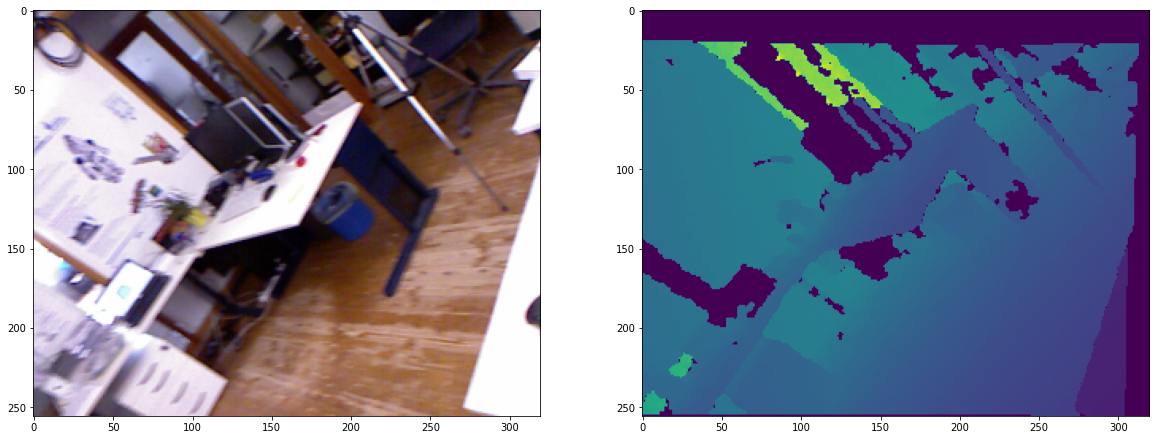

In [38]:


plt.figure(figsize=(20,20))
ax = plt.subplot(1,2,1)
ax.imshow(colors[batch_id,frame_id,:,:,:].detach().numpy().astype(np.uint))
ax = plt.subplot(1,2,2)
#ax.imshow(pred_depths[batch_id,frame_id+9,:,:,0].detach().numpy())
ax.imshow(depths[batch_id,frame_id,:,:,0].detach().numpy())


In [76]:
import imageio
import cv2
impath = "../../sample_data/dataset_TUM/rgbd_dataset_freiburg1_rpy/rgb/1305031231.025653.png"
im1 = np.asarray(imageio.imread(impath), dtype=float)

In [77]:
h = 240
w = 320
im2 = cv2.resize(
        im1.astype(float),
        (w, h),
        interpolation=cv2.INTER_LINEAR,
        )

In [78]:
h = 256
w = 320
im3 = cv2.resize(
        im1.astype(float),
        (w, h),
        interpolation=cv2.INTER_LINEAR,
        )

In [79]:
h = 256 #480/1.875
w = 342 #640/1.875
im4 = cv2.resize(
        im1.astype(float),
        (w, h),
        interpolation=cv2.INTER_LINEAR,
        )

In [80]:
im4.shape[1]

342

In [81]:
#crop image 4 to 245x320
#IMPORTANT image 4 width NEEDS to be a even number!
h_tar = 320 #target width
crop = (im4.shape[1] - h_tar)//2
im5 = im4[:,crop:im4.shape[1]-crop,:]

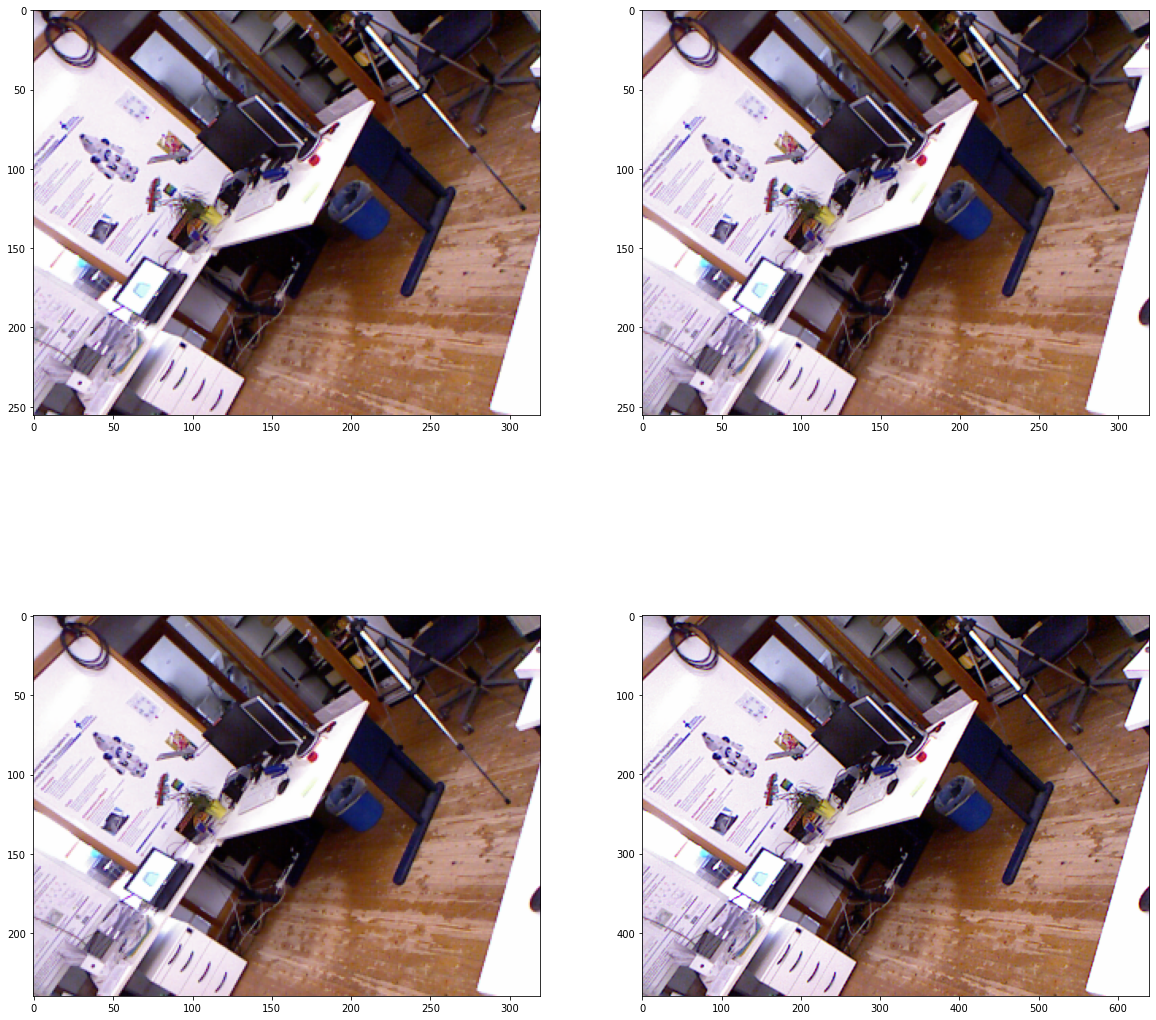

In [82]:
plt.figure(figsize=(20,20))
ax = plt.subplot(2,2,1)
ax.imshow(im5.astype(np.uint))
ax = plt.subplot(2,2,2)
ax.imshow(im3.astype(np.uint))

ax = plt.subplot(2,2,3)
ax.imshow(im2.astype(np.uint))

ax = plt.subplot(2,2,4)
ax.imshow(im1.astype(np.uint))



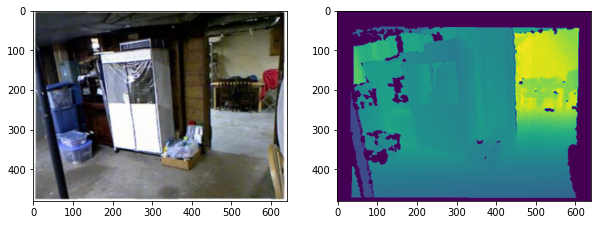

In [470]:
plt.figure(figsize=(10,10))
ax = plt.subplot(1,2,1)
ax.imshow(colors[batch_id,pred_index,:,:,:].detach().numpy().astype(np.uint))
ax = plt.subplot(1,2,2)
#ax.imshow(pred_depths[batch£_id,frame_id+9,:,:,0].detach().numpy())
ax.imshow(depths[batch_id,pred_index,:,:,0].detach().numpy())

In [471]:
color = (colors[:, pred_index, :] / 255.0).permute(0, 3, 1, 2)
pred_depths = DepthPredictor(color)

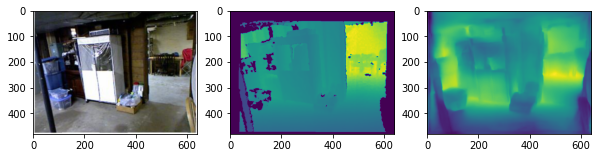

In [481]:
#batch_id = 0
plt.figure(figsize=(10,10))
ax = plt.subplot(1,3,1)
ax.imshow(color.permute(0, 2, 3,1)[batch_id,:])
ax = plt.subplot(1,3,2)
#ax.imshow(pred_depths[batch£_id,frame_id+9,:,:,0].detach().numpy())
ax.imshow(depths[batch_id,pred_index,:,:,0].detach().numpy())

ax = plt.subplot(1,3,3)
ax.imshow(pred_depths[batch_id,0,:].detach().numpy())

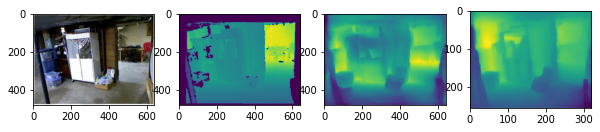

In [491]:
#batch_id = 0
plt.figure(figsize=(10,10))
ax = plt.subplot(1,4,1)
ax.imshow(color.permute(0, 2, 3,1)[batch_id,:])
ax = plt.subplot(1,4,2)
#ax.imshow(pred_depths[batch£_id,frame_id+9,:,:,0].detach().numpy())
ax.imshow(depths[batch_id,pred_index,:,:,0].detach().numpy())

ax = plt.subplot(1,4,3)
ax.imshow(pred_depths[batch_id,0,:].detach().numpy())

ax = plt.subplot(1,4,4)
ax.imshow(1/output[0][0][0,:].detach().numpy())

In [483]:
input_images = (colors[:, pred_index, :] / 255.0).permute(0, 3, 1, 2)

In [484]:
output_images = DepthPredictor.disp_net(input_images)

In [485]:
print(input_images.shape)
print(output_images[2].shape)


torch.Size([8, 3, 480, 640])
torch.Size([8, 1, 120, 160])


In [486]:
colors[:, pred_index, :].permute(0, 3, 1, 2).shape

torch.Size([8, 3, 480, 640])

In [497]:
imgs = colors[:, pred_index, :].permute(0, 3, 1, 2)
imgs = torch.nn.functional.interpolate(input=imgs, size=(256, 320), mode="bicubic")
#imgs = torch.nn.functional.interpolate(input=imgs, size=(256, 320), mode="bicubic")
#imgs = torch.nn.functional.interpolate(input=imgs, size=(480, 640), mode="bicubic")
img = imgs[batch_id,:]
img = img.numpy()
#img = np.transpose(img, (2, 0, 1))

tensor_img = torch.from_numpy(img).unsqueeze(0)
tensor_img = ((tensor_img/255)).to(device)
#tensor_img = ((tensor_img/255 - 0.45)/0.225).to(device)
input_image = tensor_img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


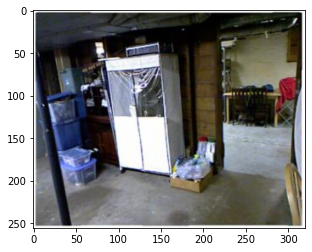

In [498]:
plt.imshow(input_image.permute(0, 2, 3,1)[0,:].detach().numpy())

In [494]:
#inference
output = DepthPredictor.disp_net(tensor_img)#[0]

RuntimeError: Sizes of tensors must match except in dimension 1. Got 44 and 43 in dimension 3 (The offending index is 1)

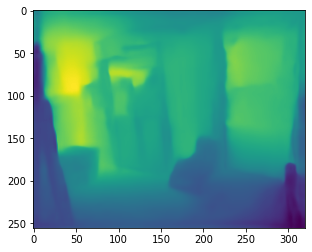

In [490]:
disp = output[0][0][0,:].detach().numpy()
plt.imshow(1/(disp-0.1))

In [274]:
pred_depths[batch_id,0,:].shape

torch.Size([480, 640])

In [159]:
batch_idx = 0

print("Getting pose loss")

# With predicted depth
#rgbdimages = RGBDImages(colors, pred_depths, intrinsics, poses, channels_first=False, device=torch.device("cpu"))
n_frames = 9
rgbdimages = RGBDImages(colors[0:1,0:n_frames], pred_depths[0:1,0:n_frames], intrinsics[0:1,0:n_frames], poses[0:1,0:n_frames], channels_first=False, device=torch.device("cpu"))

# without poses
#rgbdimages = RGBDImages(colors, pred_depths, intrinsics, channels_first=False, device=torch.device("cpu"))

odometry_test = 'icp'
slam = PointFusion(odom = odometry_test,dsratio=4, device=torch.device("cpu"))
pointclouds, recovered_poses = slam(rgbdimages)
# loss_p = pose_loss(poses, recovered_poses, device)
# writer.add_scalar("Pose/Batchwise_loss_pred", loss_p.mean().item(), counter["detailed"] )


Getting pose loss


ValueError: depth_image should have ndim=5, but had ndim=4

# Gradslam

In [162]:
slam = PointFusion(odom=args.odometry, dsratio=4, device=device)
pointclouds = Pointclouds(device=device)
prev_frame = None

# Scale intrinsics since SLAM works on downsampled images
intrinsics[:, :, 0, :] = intrinsics[:, :, 0, :] * 160 / 640
intrinsics[:, :, 1, :] = intrinsics[:, :, 1, :] * 120 / 480

In [164]:
pred_index = 0
DepthPredictor.zero_grad()

# get input tensors
input_dict = {"device": device}
input_dict["rgb"] = (colors[:, pred_index, ::] / 255.0).permute(0, 3, 1, 2)
input_dict["rgb_ref"] = (colors[:, pred_index - 1, ::] / 255.0).permute(0, 3, 1, 2)
# Initial poses are necessary. We use identity here, could also use gt
input_dict["pose"] = torch.eye(4, device=device).view(1, 4, 4).repeat(args.batch_size, 1, 1)
# input_dict["pose"] = torch.matmul(torch.inverse(poses[:, pred_index - 1, ::]), poses[:, pred_index, ::])
input_dict["depth"] = depths[:, pred_index, ::].permute(0, 3, 1, 2)
input_dict["intrinsic"] = intrinsics

In [167]:
#input_dict, slam, pointclouds, prev_frame, args.debug_path

({'device': device(type='cpu'),
  'rgb': tensor([[[[0.9961, 0.9961, 0.9961,  ..., 0.9775, 0.9637, 0.9569],
            [0.9961, 0.9934, 0.9881,  ..., 0.9842, 0.9746, 0.9698],
            [0.9961, 0.9887, 0.9740,  ..., 0.9962, 0.9940, 0.9928],
            ...,
            [0.9542, 0.9559, 0.9592,  ..., 0.9727, 0.9822, 0.9869],
            [0.9835, 0.9841, 0.9853,  ..., 0.9826, 0.9911, 0.9953],
            [1.0000, 1.0000, 1.0000,  ..., 0.9882, 0.9961, 1.0000]],
  
           [[1.0000, 1.0000, 1.0000,  ..., 0.9696, 0.9559, 0.9490],
            [1.0000, 0.9976, 0.9929,  ..., 0.9775, 0.9679, 0.9631],
            [1.0000, 0.9935, 0.9804,  ..., 0.9917, 0.9894, 0.9882],
            ...,
            [0.9542, 0.9559, 0.9592,  ..., 0.9650, 0.9748, 0.9797],
            [0.9835, 0.9841, 0.9853,  ..., 0.9755, 0.9853, 0.9902],
            [1.0000, 1.0000, 1.0000,  ..., 0.9814, 0.9912, 0.9961]],
  
           [[1.0000, 1.0000, 1.0000,  ..., 0.9814, 0.9676, 0.9608],
            [1.0000, 0.9974, 0.9921

In [ ]:
#self = DepthPredictor

# get inputs
colors = input_dict["rgb"]
intrinsics = input_dict["intrinsic"]
poses = input_dict["pose"]

# predict depth
pred_depths = DepthPredictor(colors)

In [179]:

# Ground truth Depth for comparison (only for debug)
#if DEBUG_PATH:
#    gt_depths = input_dict["depth"]
#    gt_depths = torch.nn.functional.interpolate(input=gt_depths, size=(120, 160), mode="nearest")
#    gt_depths_u = torch.unsqueeze(gt_depths, 1).permute(0, 1, 3, 4, 2)

# Downsample (since depth prediction does not work in (120,160))
colors = torch.nn.functional.interpolate(input=colors, size=(120, 160), mode="bicubic")
pred_depths = torch.nn.functional.interpolate(input=pred_depths, size=(120, 160), mode="nearest")

# added artificial sequence length dimension and then don't use it (stupid but necessary)
# permute since slam does NOT support channels_first = True
colors_u = torch.unsqueeze(colors, 1).permute(0, 1, 3, 4, 2)
pred_depths_u = torch.unsqueeze(pred_depths, 1).permute(0, 1, 3, 4, 2)
poses_u = torch.unsqueeze(poses, 1)

In [183]:
# SLAM
rgbdimages = RGBDImages(colors_u, pred_depths_u, intrinsics, poses_u, channels_first=False, device=self.device)
live_frame = rgbdimages[:, 0]
pointclouds, live_frame.poses = slam.step(pointclouds, live_frame, prev_frame)


In [202]:
import open3d as o3d
o3d.visualization.draw_geometries([pointclouds.open3d(0)])

NameError: name 'o3d' is not defined

# DEPTH FROM SLAM

In [241]:
from kornia.geometry.linalg import inverse_transformation
from gradslam.geometry.geometryutils import create_meshgrid 

In [205]:
# Similar to gradslam.fusionutils.find_active_map_points
# Todo: take confidence into account

batch_size, seq_len, height, width = live_frame.shape

# Transform pointcloud to live frame pose
tinv = inverse_transformation(live_frame.poses.squeeze(1))
pointclouds_transformed = pointclouds.transform(tinv)
# don't consider missing depth values (z < 0)
is_front_of_plane = (
    pointclouds_transformed.points_padded[..., -1] > 0
)

# Get depths from transformed pointcloud
depths_padded = pointclouds_transformed.points_padded[..., -1]
depths_padded = torch.unsqueeze(depths_padded, 2)

# Project pointcloud into live frame (IN PLACE operation)
pointclouds_transformed.pinhole_projection_(
    live_frame.intrinsics.squeeze(1)
)



In [221]:
pointclouds.points_padded.shape
pointclouds.points_padded.grad_fn

In [227]:
pointclouds.points_padded.mean().backward()

In [239]:
par = next(iter(DepthPredictor.parameters()))
par.grad

tensor([[[[ 1.2610e-07,  7.2454e-07,  7.3810e-06,  ...,  2.2812e-05,
            2.9654e-05,  3.3584e-05],
          [ 5.1079e-06,  5.0608e-06,  1.1655e-05,  ...,  2.8137e-05,
            3.5617e-05,  4.0385e-05],
          [ 1.1390e-05,  1.1425e-05,  1.7903e-05,  ...,  3.3273e-05,
            3.9453e-05,  4.3992e-05],
          ...,
          [ 2.1268e-05,  2.0235e-05,  2.4848e-05,  ...,  3.5783e-05,
            4.1018e-05,  4.5622e-05],
          [ 2.2556e-05,  2.1524e-05,  2.5987e-05,  ...,  3.6375e-05,
            4.1502e-05,  4.5922e-05],
          [ 2.5502e-05,  2.4486e-05,  2.8956e-05,  ...,  3.9446e-05,
            4.4775e-05,  4.9177e-05]],

         [[ 1.4719e-05,  1.5739e-05,  2.2723e-05,  ...,  3.8536e-05,
            4.5435e-05,  4.9404e-05],
          [ 1.9998e-05,  2.0531e-05,  2.7451e-05,  ...,  4.4136e-05,
            5.1772e-05,  5.6636e-05],
          [ 2.6484e-05,  2.7162e-05,  3.3953e-05,  ...,  4.9376e-05,
            5.5695e-05,  6.0332e-05],
          ...,
     

In [256]:
# Discard depth, only keep width and height
img_plane_points = pointclouds_transformed.points_padded[..., :-1]

# Mask for eliminating points that are not inside image
is_in_frame = (
    (img_plane_points[..., 0] > -1e-3)
    & (img_plane_points[..., 0] < width - 0.999)
    & (img_plane_points[..., 1] > -1e-3)
    & (img_plane_points[..., 1] < height - 0.999)
    & is_front_of_plane
    & pointclouds.nonpad_mask
)

in_plane_pos = img_plane_points.round().long()

In [257]:
print(img_plane_points.shape)
print(is_in_frame.shape)
in_plane_pos.grad_fn

torch.Size([8, 19200, 2])
torch.Size([8, 19200])


In [240]:

in_plane_pos = torch.cat(
    [
        in_plane_pos[..., 1:2].clamp(0, height - 1),
        in_plane_pos[..., 0:1].clamp(0, width - 1),
    ],
    -1,
)  # height, width
batch_size, num_points = in_plane_pos.shape[:2]
batch_point_idx = (
    create_meshgrid(batch_size, num_points, normalized_coords=False)
    .squeeze(0)
    .to(pointclouds.device)
)


NameError: name 'create_meshgrid' is not defined

In [ ]:
# Create a lookup table pc2im_bnhw that stores all points from pointcloud (referenced by point_cloud_index,
# that are active in current frame (at pixel height_index, width_index).
# Shape: (num_points, 4) with 4 columns [batch_index, point_cloud_index, height_index, width_index]
idx_and_plane_pos = torch.cat([batch_point_idx.long(), in_plane_pos], -1)
pc2im_bnhw = idx_and_plane_pos[is_in_frame]  # (?, 4)

# Use lookup table to get depth of active points (= reprojected depth)
proj_depth = torch.zeros_like(live_frame.depth_image)
proj_depth[pc2im_bnhw[:, 0], 0, pc2im_bnhw[:, 2], pc2im_bnhw[:, 3], :] = \
    depths_padded[pc2im_bnhw[:, 0], pc2im_bnhw[:, 1]]

# Use lookup table to get color of active points (= reprojected color)
proj_colors = torch.zeros_like(live_frame.rgb_image)
proj_colors[pc2im_bnhw[:, 0], 0, pc2im_bnhw[:, 2], pc2im_bnhw[:, 3], :] = \
    pointclouds.colors_padded[pc2im_bnhw[:, 0], pc2im_bnhw[:, 1]]

if pc2im_bnhw.shape[0] == 0:
    warnings.warn("No active map points were found")

In [182]:
# Get depth map from SLAM # TODO: can try again with find_correspondences to incorporate uncertainty?
proj_colors, proj_depths = depthfromslam(pointclouds, live_frame)

# Compute Loss
error = self.get_depth_error(pred_depths, proj_depths[:, :, :, :, 0].detach())

NameError: name 'depthfromslam' is not defined

In [ ]:
# Visualizations: Change path
        if DEBUG_PATH:
            # Projected Color Vis
            vis_proj_color = proj_colors[0, 0, :, :, :].detach().cpu().numpy()
            imageio.imwrite(os.path.join(DEBUG_PATH, "debug_color_proj.png"), vis_proj_color)
            # Projected Depth Vis
            vis_proj_depth = proj_depths[0, 0, :, :, :].detach().cpu().numpy()
            vmax = np.percentile(vis_proj_depth, 95)
            vmin = vis_proj_depth.min()
            normalizer = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
            mapper = cm.ScalarMappable(norm=normalizer, cmap='magma')
            proj_depth_np = (mapper.to_rgba(vis_proj_depth[:, :, 0])[:, :, :3] * 255).astype(np.uint8)
            imageio.imwrite(os.path.join(DEBUG_PATH, "debug_depth_proj.png"), proj_depth_np)
            # Color vis
            vis_color = live_frame.rgb_image[0, 0, :, :, :].detach().cpu().numpy()
            imageio.imwrite(os.path.join(DEBUG_PATH, "debug_color.png"), vis_color)
            # Depth Vis
            vis_pred_depth = live_frame.depth_image[0, 0, :, :, :].detach().cpu().numpy()
            vmax = np.percentile(vis_pred_depth, 95)
            vmin = vis_pred_depth.min()
            normalizer = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
            mapper = cm.ScalarMappable(norm=normalizer, cmap='magma')
            pred_depth_np = (mapper.to_rgba(vis_pred_depth[:, :, 0])[:, :, :3] * 255).astype(np.uint8)
            imageio.imwrite(os.path.join(DEBUG_PATH, "debug_depth_proj.png"), pred_depth_np)
            # SLAM Vis
            import open3d as o3d
            o3d.visualization.draw_geometries([pointclouds.open3d(0)])

# NYU shit

In [ ]:
#create empty object and attach attributes, to simulate command line arguments
class Args: pass
args = Args()

args.dataset = "tum"
args.dataset_path = "../../sample_data/dataset_TUM/"
args.odometry = "icp"
args.sequences = None

args.debug_path = None
args.seq_length = 10
args.batch_size = 8
args.loss = 'depth_consistency'